In [65]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (20, 5)
mpl.rcParams['axes.grid'] = False
plt.style.use('ggplot')

In [66]:
# creating a dataframe from the csv file
df = pd.DataFrame(pd.read_csv('../output/zero4_outputs.csv'))
df = df.drop([df.columns[0]], axis='columns') 
df = df.iloc[:,:-3]
df.reset_index(drop=True, inplace=True)
  
# Change UTC Time to CST Time 
from datetime import datetime

CST_time_list = []
for time in df['Time'].to_list():
    CST_time_list.append(datetime.fromtimestamp(time))

df['Time'] = pd.DataFrame(CST_time_list)

# Date Time: Minutes Seconds
# df.index = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S')
date_time = df['Time'].dt.strftime('%M %S')

# checking our dataframe once again
df.head()

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_49,Subcar_50,Subcar_51,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58
0,2022-01-08 08:35:42,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,575.782077,520.239368,471.936436,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079
1,2022-01-08 08:35:43,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,455.247186,423.709806,390.858030,367.766230,339.484904,339.087010,343.083080,343.739727,346.943800,351.039884
2,2022-01-08 08:35:44,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,672.899695,599.141052,524.108767,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791
3,2022-01-08 08:35:45,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,610.351538,538.108725,508.141712,459.243944,413.706418,406.503382,392.998728,389.802514,381.072172,390.508643
4,2022-01-08 08:35:46,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,788.428817,729.188590,698.148981,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355


<AxesSubplot:>

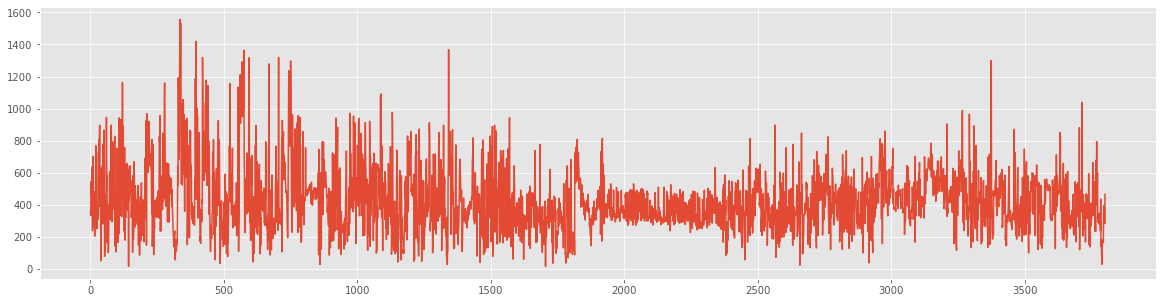

In [67]:
temp = df['Subcar_7']
temp.plot()

In [68]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + 5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [69]:
WINDOW_SIZE = 144
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((3658, 5, 1), (3658,))

In [70]:
x_train, y_train = X[:2000], y[:2000]
x_test, y_test = X[700:750], y[700:750]
x_val, y_val = X[750:], y[750:]


x_train, y_train = X[:2000], y[:2000]
x_test, y_test = X[700:750], y[700:750]
x_val, y_val = X[750:], y[750:]

# train data normalisation
x_train_mean = x_train.mean()
y_train_mean = y_train.mean()

x_train_std = x_train.std()
y_train_std = y_train.std()

x_train = (x_train - x_train_mean) / x_train_std

# test validation data normalisation
x_test_mean = x_test.mean()
y_test_mean = y_test.mean()

x_test_std = x_test.std()
y_test_std = y_train.std()

x_test = (x_test - x_test_mean) / x_test_std

# validation data normalisation
x_val_mean = x_val.mean()
y_val_mean = y_val.mean()

x_val_std = x_val.std()
y_val_std = y_val.std()

x_val = (x_val - x_val_mean) / x_val_std


print('x_train set:', x_train.shape)
print('y_train set:', y_train.shape)
print('x_test set:', x_test.shape)
print('y_test:', y_test.shape)
print('x_val set:', x_val.shape)
print('y_val set:', y_val.shape)

x_train set: (2000, 5, 1)
y_train set: (2000,)
x_test set: (50, 5, 1)
y_test: (50,)
x_val set: (2908, 5, 1)
y_val set: (2908,)


In [71]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [73]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(Conv1D(64, kernel_size=2))
model1.add(Conv1D(32, kernel_size= 2))
model1.add(Flatten())
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3, 32)             4128      
_________________________________________________________________
flatten_3 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 776       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 5,105
Trainable params: 5,105
Non-trainable params: 0
_________________________________________________________________


In [74]:
cp = ModelCheckpoint('../save/model1/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [75]:
model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[early_stopping,cp])

Epoch 1/100
63/63 [==============================] - 1s 10ms/step - loss: 247037.8125 - mean_absolute_error: 440.2917 - val_loss: 191385.8594 - val_mean_absolute_error: 406.0882
Epoch 2/100
63/63 [==============================] - 1s 9ms/step - loss: 246522.7344 - mean_absolute_error: 439.7983 - val_loss: 190911.5781 - val_mean_absolute_error: 405.5393
Epoch 3/100
63/63 [==============================] - 1s 9ms/step - loss: 245802.6094 - mean_absolute_error: 439.0916 - val_loss: 190198.3750 - val_mean_absolute_error: 404.7169
Epoch 4/100
63/63 [==============================] - 1s 10ms/step - loss: 244735.6094 - mean_absolute_error: 438.0437 - val_loss: 189128.7344 - val_mean_absolute_error: 403.4888
Epoch 5/100
63/63 [==============================] - 1s 9ms/step - loss: 243149.2031 - mean_absolute_error: 436.5047 - val_loss: 187589.7656 - val_mean_absolute_error: 401.7217
Epoch 6/100
63/63 [==============================] - 1s 9ms/step - loss: 240785.1719 - mean_absolute_error: 434.2

In [76]:
from tensorflow.keras.models import load_model
model1 = load_model('../save/model1/')

In [77]:
train_predictions1 = model1.predict(x_train).flatten()
train_results1 = pd.DataFrame(data={'Train Predictions': train_predictions1, 'Actuals': y_train})
train_results1

,Train Predictions,Actuals
0,449.298889,587.749096
1,478.029846,635.824661
2,507.812805,360.188839
3,492.658142,237.118114
4,436.247864,507.607131
...,...,...
1995,371.753357,321.810503
1996,367.268738,366.890992
1997,372.952362,323.975308
1998,375.556213,329.789327


In [78]:
mape(train_predictions1, y_train)

34.06157809020879

Text(0, 0.5, 'Amplitude')

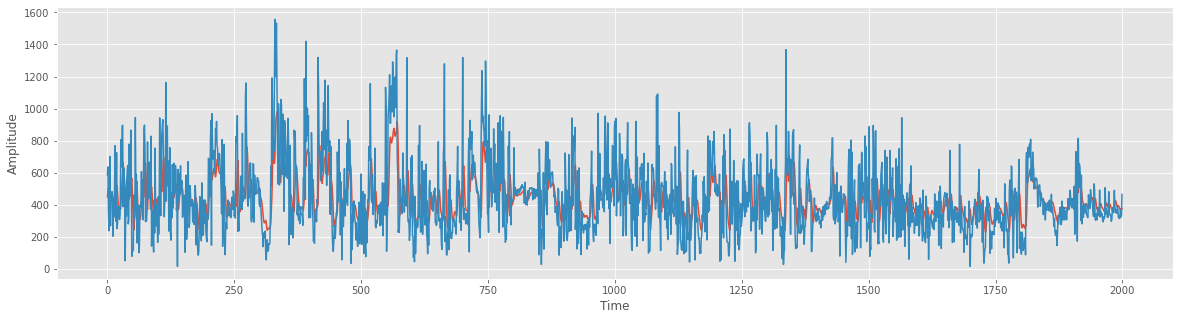

In [79]:
plt.plot(train_results1['Train Predictions'])
plt.plot(train_results1['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

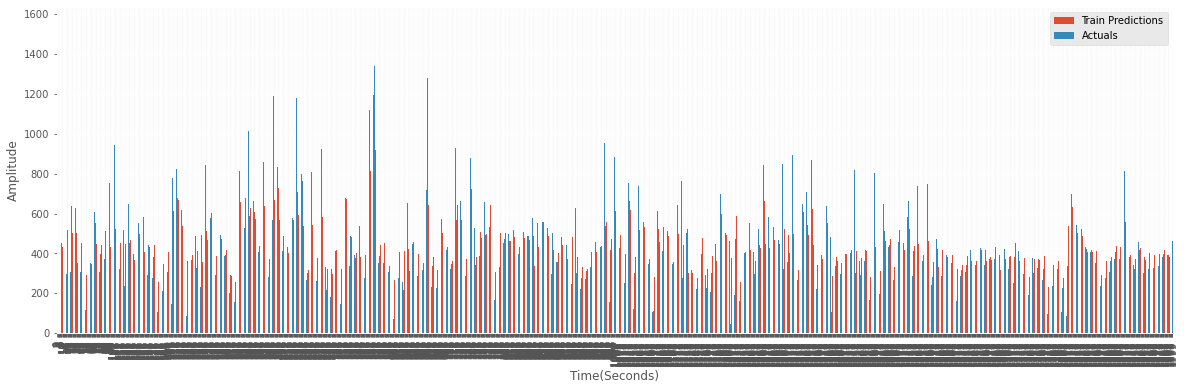

In [80]:
fig,ax = plt.subplots(figsize=(20,6))
train_results1.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

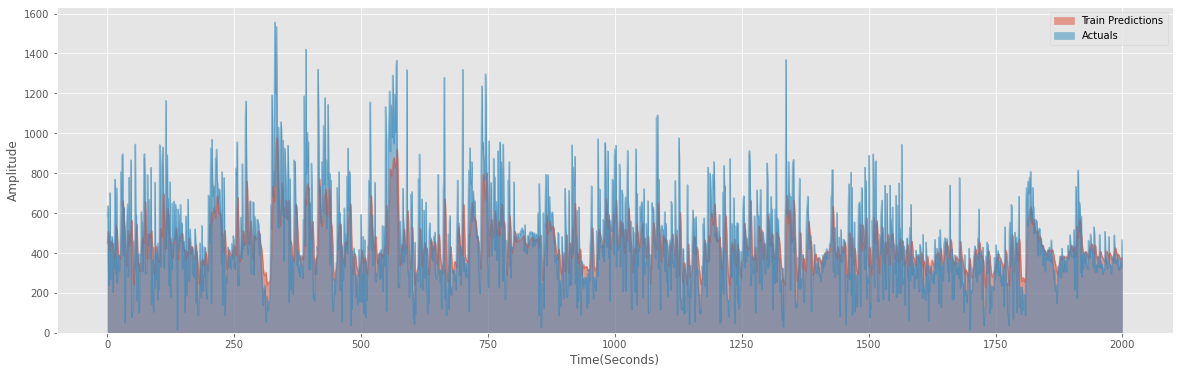

In [81]:
fig,ax = plt.subplots(figsize=(20,6))
train_results1.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [82]:
val_predictions1 = model1.predict(x_val).flatten()
val_results1 = pd.DataFrame(data={'Val predictions': val_predictions1, 'Actuals': y_val})
val_results1

,Val predictions,Actuals
0,646.870422,340.834271
1,491.436310,228.319951
2,387.297424,961.095729
3,485.740906,484.530701
4,562.839844,535.452145
...,...,...
2903,448.673157,381.808853
2904,392.741272,278.167216
2905,350.441589,195.205020
2906,322.079651,607.356567


In [83]:
mape(val_predictions1, y_val)

27.638716974749496

Text(0, 0.5, 'Amplitude')

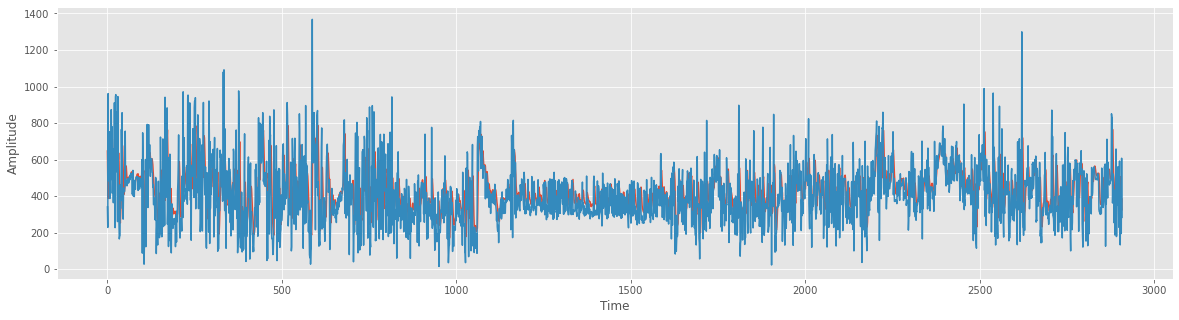

In [84]:
plt.plot(val_results1['Val predictions'])
plt.plot(val_results1['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

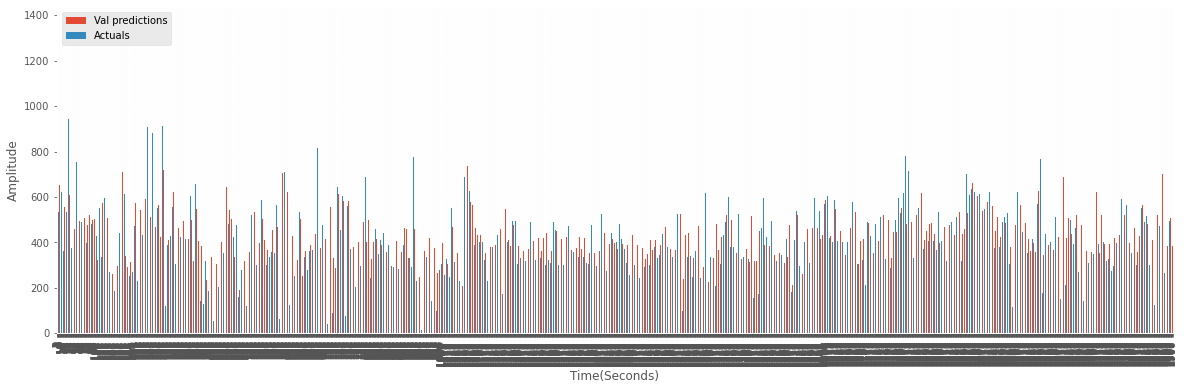

In [85]:
fig,ax = plt.subplots(figsize=(20,6))
val_results1.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

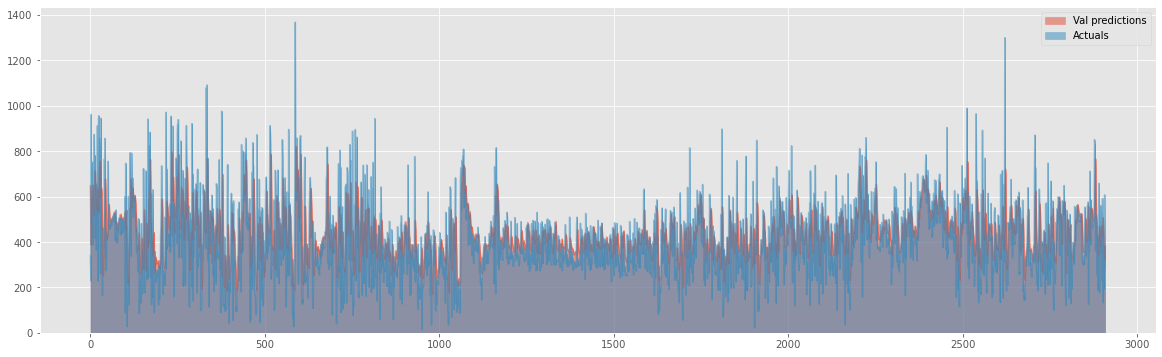

In [86]:
fig,ax = plt.subplots(figsize=(20,6))
val_results1.plot(kind='area',ax=ax,stacked=False)
plt.show()

In [87]:
test_predictions1 = model1.predict(x_test).flatten()
test_results1 = pd.DataFrame(data={'Test predictions': test_predictions1, 'Actuals': y_test})
test_results1

,Test predictions,Actuals
0,354.275391,1318.891959
1,482.484589,427.907700
2,523.182861,308.974109
3,471.448425,375.431752
4,387.222534,315.995253
5,325.719177,323.487249
6,309.705139,281.128085
7,300.940063,346.161812
8,299.891266,294.266886
9,298.353760,291.756748


In [88]:
mape(test_predictions1, y_test)

53.54525674293637

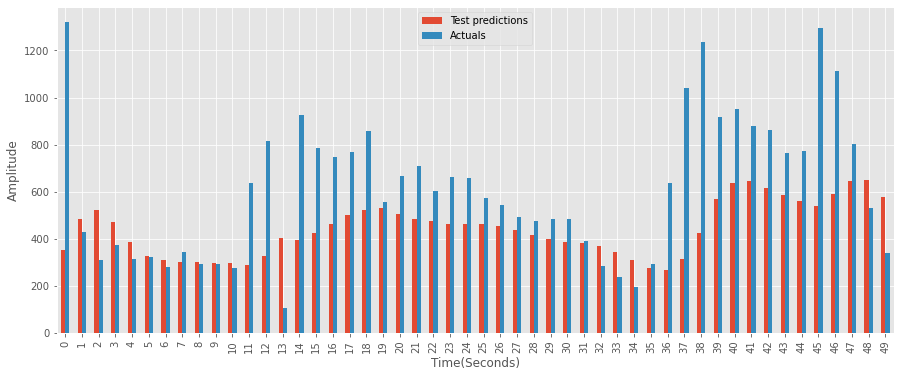

In [89]:
fig,ax = plt.subplots(figsize=(15,6))
test_results1.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

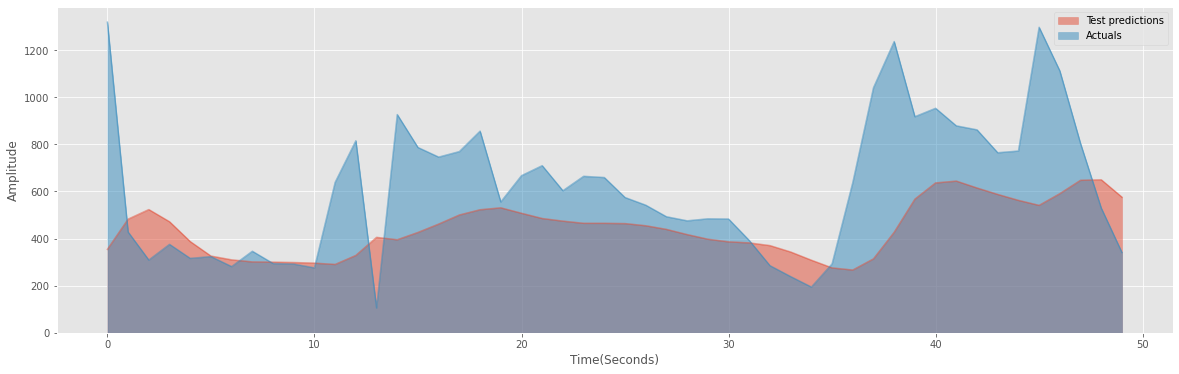

In [90]:
fig,ax = plt.subplots(figsize=(20,6))
test_results1.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

Text(0, 0.5, 'Amplitude')

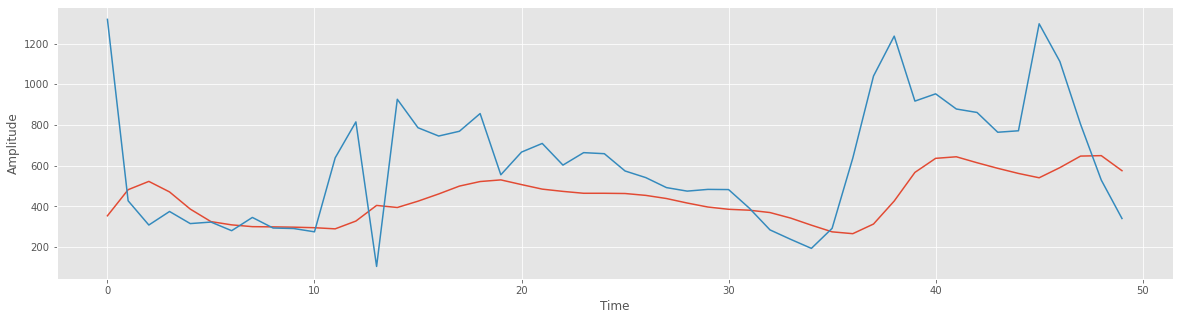

In [91]:
plt.plot(test_results1['Test predictions'])
plt.plot(test_results1['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

In [92]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Conv1D(32, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(32, 'relu'))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3, 32)             4128      
_________________________________________________________________
flatten_4 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                3104      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 7,697
Trainable params: 7,697
Non-trainable params: 0
____________________________________________________

In [93]:
cp2 = ModelCheckpoint('../save/model2/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [94]:
model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, callbacks=[early_stopping,cp2])

Epoch 1/50
63/63 [==============================] - 1s 12ms/step - loss: 247200.2031 - mean_absolute_error: 440.4662 - val_loss: 191588.8906 - val_mean_absolute_error: 406.3294
Epoch 2/50
63/63 [==============================] - 1s 11ms/step - loss: 246836.8125 - mean_absolute_error: 440.1179 - val_loss: 191165.0312 - val_mean_absolute_error: 405.8524
Epoch 3/50
63/63 [==============================] - 1s 11ms/step - loss: 246067.9531 - mean_absolute_error: 439.4116 - val_loss: 190313.1562 - val_mean_absolute_error: 404.8881
Epoch 4/50
63/63 [==============================] - 1s 10ms/step - loss: 244556.1562 - mean_absolute_error: 437.9598 - val_loss: 188582.4531 - val_mean_absolute_error: 402.9131
Epoch 5/50
63/63 [==============================] - 1s 21ms/step - loss: 241515.6094 - mean_absolute_error: 435.0829 - val_loss: 185152.5938 - val_mean_absolute_error: 398.9611
Epoch 6/50
63/63 [==============================] - 1s 10ms/step - loss: 235593.7656 - mean_absolute_error: 429.314

In [95]:
from tensorflow.keras.models import load_model
model2 = load_model('../save/model2/')

In [96]:
train_predictions2 = model2.predict(x_train).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions': train_predictions2, 'Actuals': y_train})
train_results2

,Train Predictions,Actuals
0,446.028229,587.749096
1,474.824799,635.824661
2,509.676575,360.188839
3,502.035919,237.118114
4,441.302216,507.607131
...,...,...
1995,363.341003,321.810503
1996,357.149994,366.890992
1997,361.560791,323.975308
1998,365.847443,329.789327


In [97]:
mape(train_predictions2, y_train)

34.600193726692346

Text(0, 0.5, 'Amplitude')

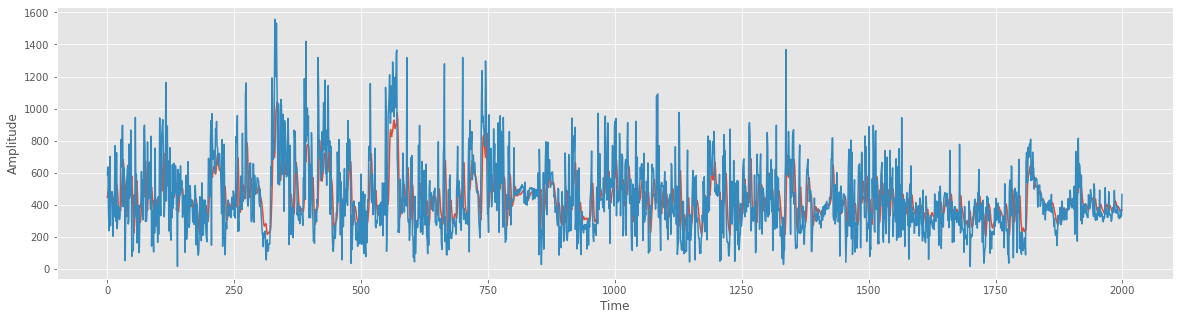

In [98]:
plt.plot(train_results2['Train Predictions'])
plt.plot(train_results2['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

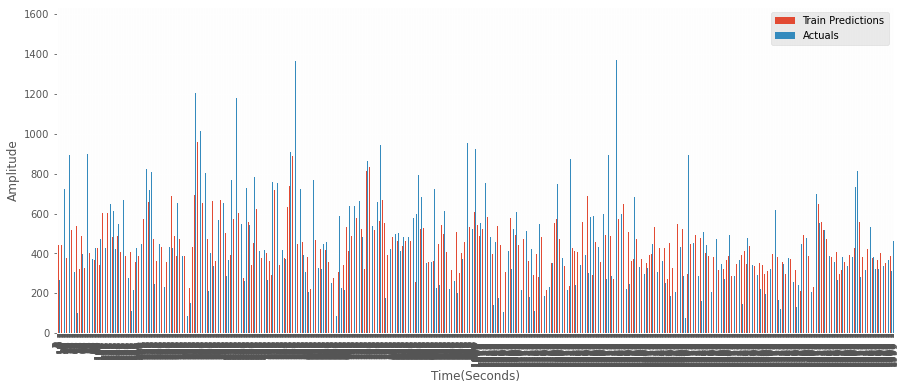

In [99]:
fig,ax = plt.subplots(figsize=(15,6))
train_results2.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

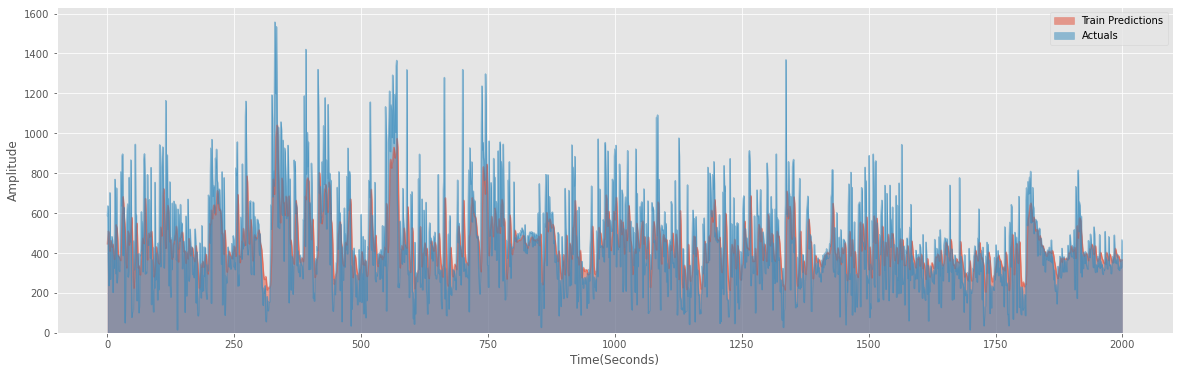

In [100]:
fig,ax = plt.subplots(figsize=(20,6))
train_results2.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [101]:
val_predictions2 = model2.predict(x_val).flatten()
val_results2 = pd.DataFrame(data={'Val predictions': val_predictions2, 'Actuals': y_val})
val_results2

,Val predictions,Actuals
0,706.627930,340.834271
1,520.974976,228.319951
2,397.196381,961.095729
3,469.237823,484.530701
4,571.577881,535.452145
...,...,...
2903,456.094025,381.808853
2904,390.025513,278.167216
2905,347.545044,195.205020
2906,312.074829,607.356567


In [102]:
mape(val_predictions2, y_val)

28.560257959468828

Text(0, 0.5, 'Amplitude')

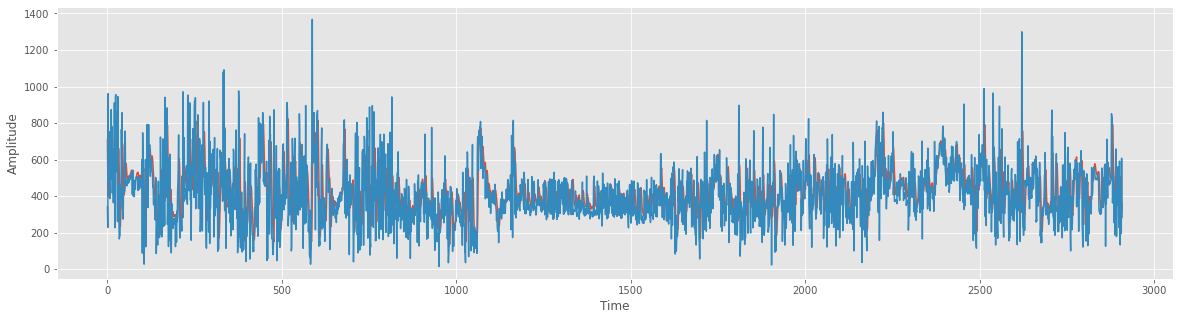

In [103]:
plt.plot(val_results2['Val predictions'])
plt.plot(val_results2['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

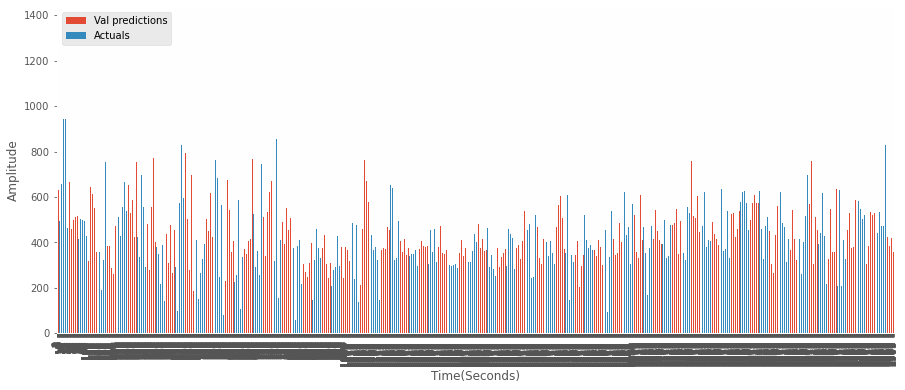

In [104]:
fig,ax = plt.subplots(figsize=(15,6))
val_results2.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

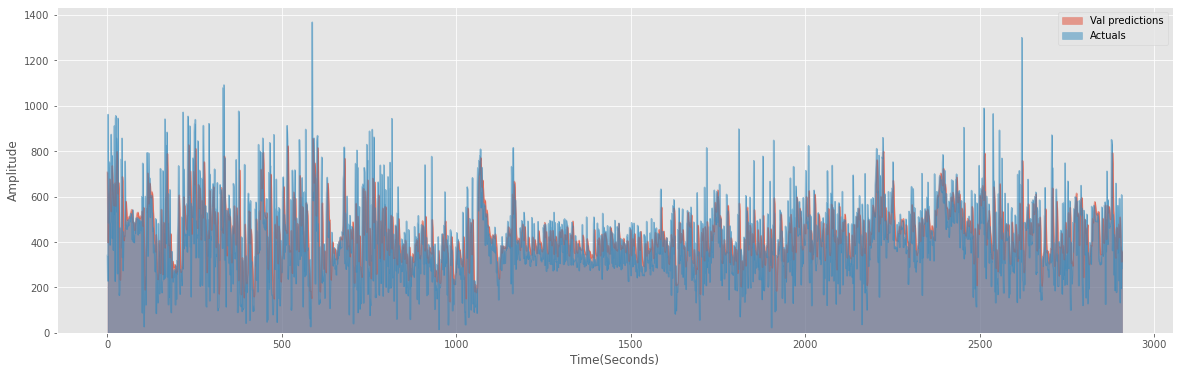

In [105]:
fig,ax = plt.subplots(figsize=(20,6))
val_results2.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [106]:
test_predictions2 = model2.predict(x_test).flatten()
test_results2 = pd.DataFrame(data={'Test predictions': test_predictions2, 'Actuals': y_test})
test_results2

,Test predictions,Actuals
0,336.730164,1318.891959
1,465.320831,427.907700
2,530.229065,308.974109
3,478.338806,375.431752
4,388.939301,315.995253
5,324.502350,323.487249
6,293.069031,281.128085
7,282.933014,346.161812
8,280.749420,294.266886
9,279.463623,291.756748


In [107]:
mape(test_predictions2,y_test)

55.51098783974213

Text(0, 0.5, 'Amplitude')

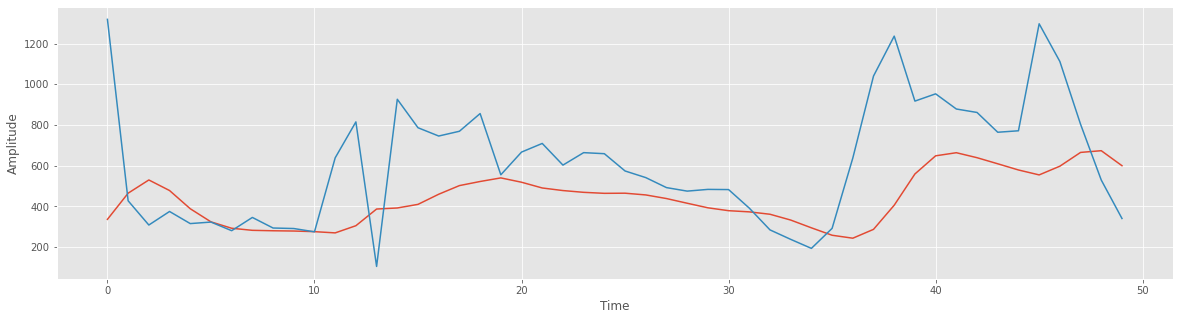

In [108]:
plt.plot(test_results2['Test predictions'])
plt.plot(test_results2['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

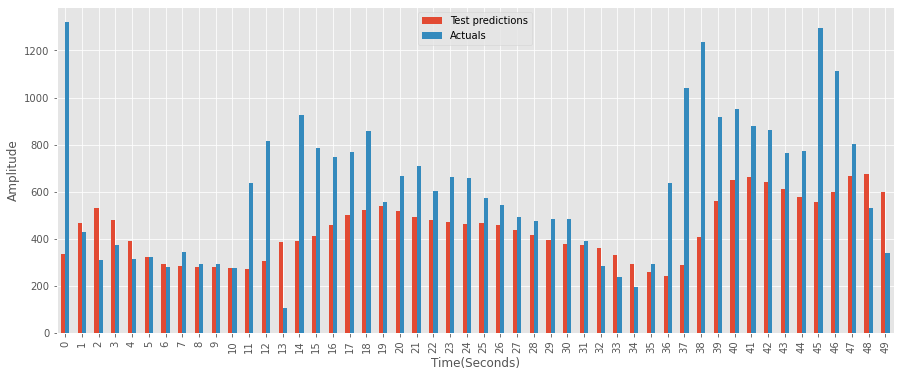

In [109]:
fig,ax = plt.subplots(figsize=(15,6))
test_results2.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

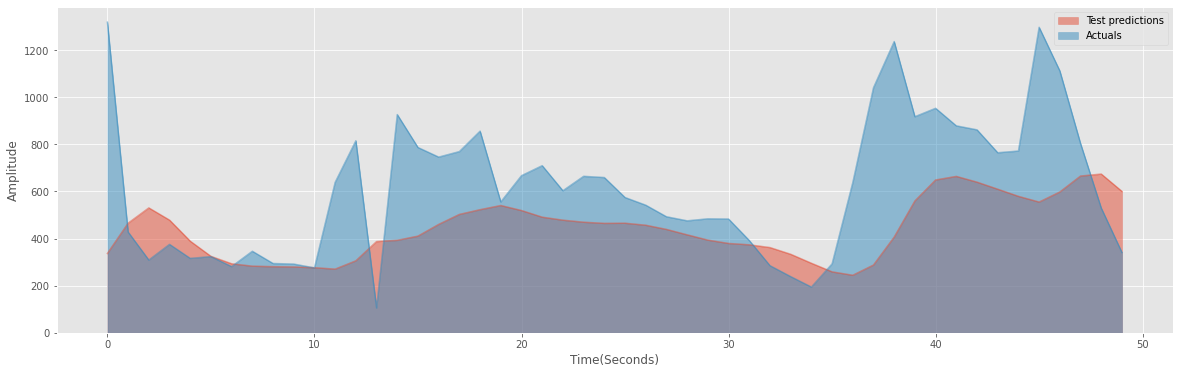

In [110]:
fig,ax = plt.subplots(figsize=(20,6))
test_results2.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [111]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(Conv1D(64, kernel_size=2))
model3.add(Flatten())
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [112]:
cp3 = ModelCheckpoint('../save/model3/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [113]:
model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, callbacks=[early_stopping,cp3])

Epoch 1/50
63/63 [==============================] - 1s 9ms/step - loss: 247368.2656 - mean_absolute_error: 440.6641 - val_loss: 191760.8594 - val_mean_absolute_error: 406.5471
Epoch 2/50
63/63 [==============================] - 0s 8ms/step - loss: 247118.2656 - mean_absolute_error: 440.4268 - val_loss: 191574.7188 - val_mean_absolute_error: 406.3379
Epoch 3/50
63/63 [==============================] - 0s 8ms/step - loss: 246903.6406 - mean_absolute_error: 440.2316 - val_loss: 191407.7188 - val_mean_absolute_error: 406.1574
Epoch 4/50
63/63 [==============================] - 1s 8ms/step - loss: 246690.5312 - mean_absolute_error: 440.0430 - val_loss: 191227.1094 - val_mean_absolute_error: 405.9641
Epoch 5/50
63/63 [==============================] - 1s 8ms/step - loss: 246451.7031 - mean_absolute_error: 439.8376 - val_loss: 191022.2344 - val_mean_absolute_error: 405.7451
Epoch 6/50
63/63 [==============================] - 0s 8ms/step - loss: 246167.6562 - mean_absolute_error: 439.5932 - va

In [114]:
train_predictions3 = model3.predict(x_train).flatten()
train_results3 = pd.DataFrame(data={'Train Predictions': train_predictions3, 'Actuals': y_train})
train_results3

,Train Predictions,Actuals
0,78.987488,587.749096
1,113.667740,635.824661
2,158.617065,360.188839
3,160.219620,237.118114
4,121.202133,507.607131
...,...,...
1995,13.615725,321.810503
1996,2.987073,366.890992
1997,4.148486,323.975308
1998,6.921761,329.789327


In [115]:
mape(train_predictions3, y_train)

2113.478115540487

Text(0, 0.5, 'Amplitude')

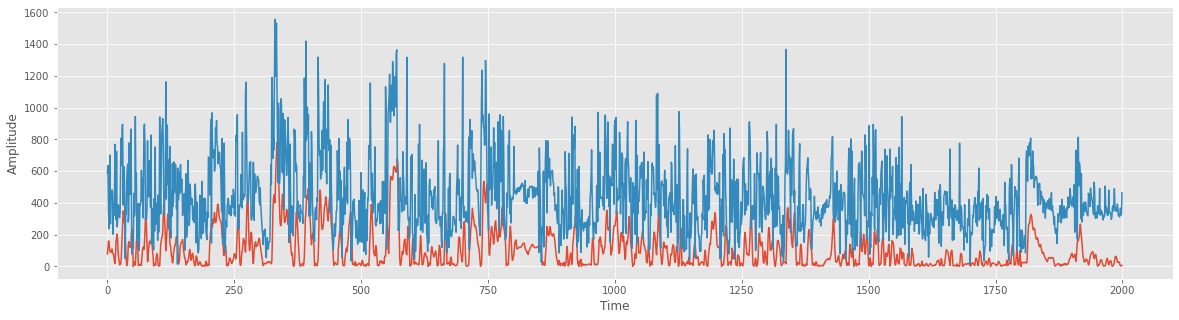

In [116]:
plt.plot(train_results3['Train Predictions'])
plt.plot(train_results3['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

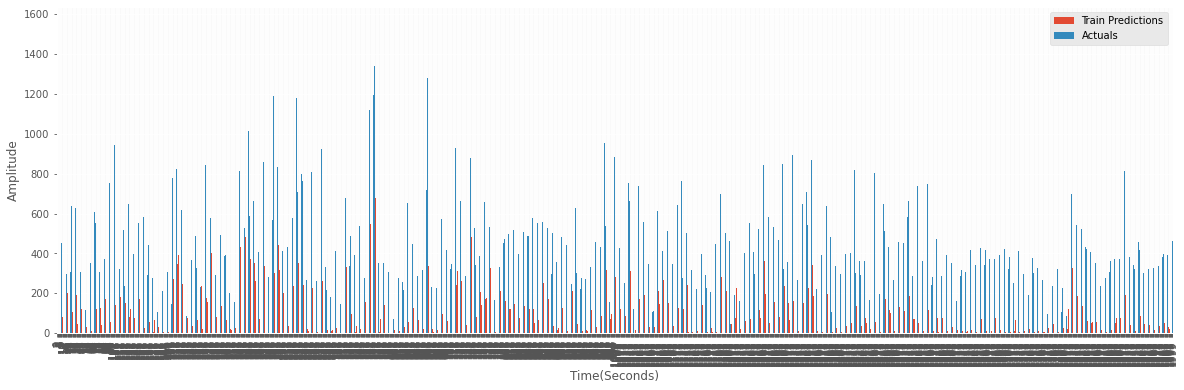

In [117]:
fig,ax = plt.subplots(figsize=(20,6))
train_results3.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

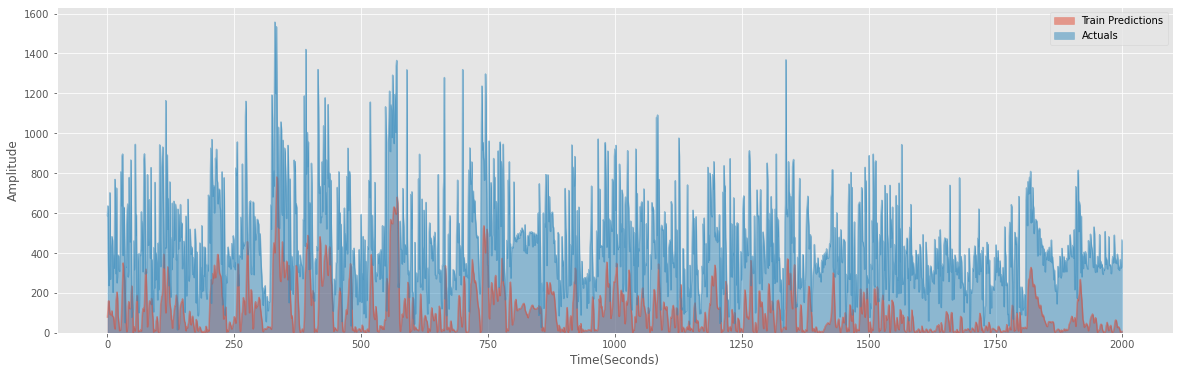

In [118]:
fig,ax = plt.subplots(figsize=(20,6))
train_results3.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [119]:
val_predictions3 = model3.predict(x_val).flatten()
val_results3 = pd.DataFrame(data={'Val predictions': val_predictions3, 'Actuals': y_val})
val_results3

,Val predictions,Actuals
0,532.956726,340.834271
1,296.704681,228.319951
2,113.482735,961.095729
3,98.585846,484.530701
4,177.736526,535.452145
...,...,...
2903,120.595474,381.808853
2904,90.031685,278.167216
2905,30.236755,195.205020
2906,9.510788,607.356567


In [120]:
mape(val_predictions3, y_val)

2461.177298466873

Text(0, 0.5, 'Amplitude')

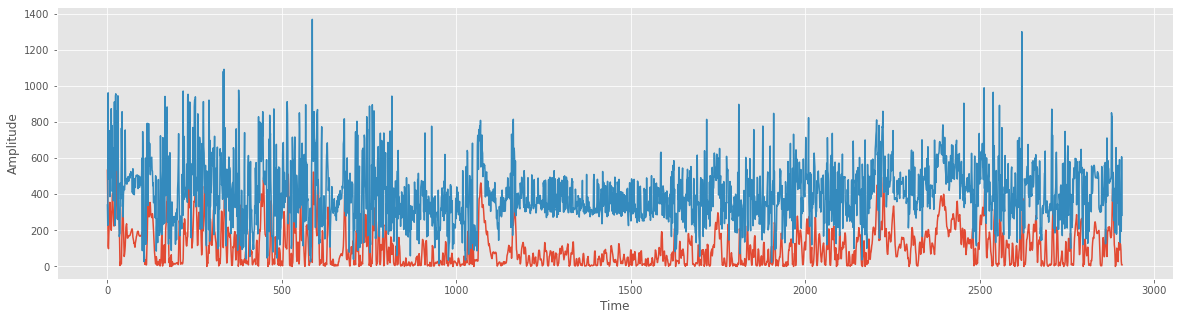

In [121]:
plt.plot(val_results3['Val predictions'])
plt.plot(val_results3['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

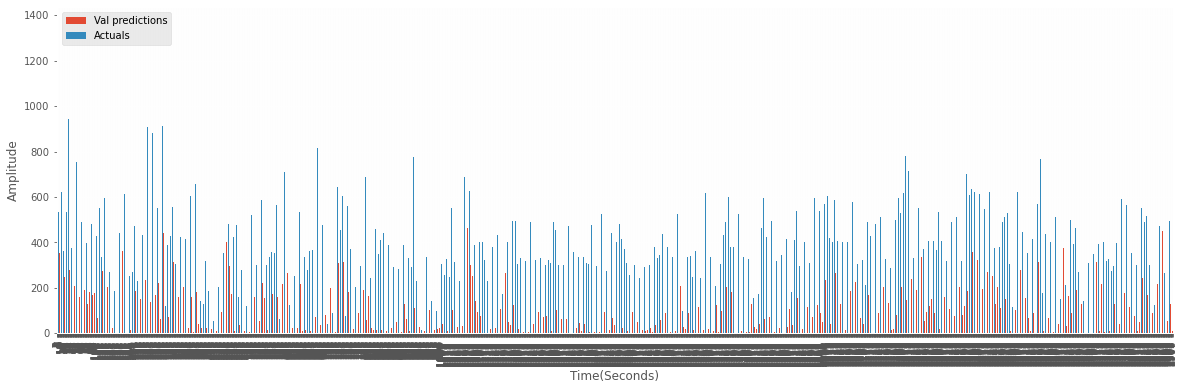

In [122]:
fig,ax = plt.subplots(figsize=(20,6))
val_results3.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

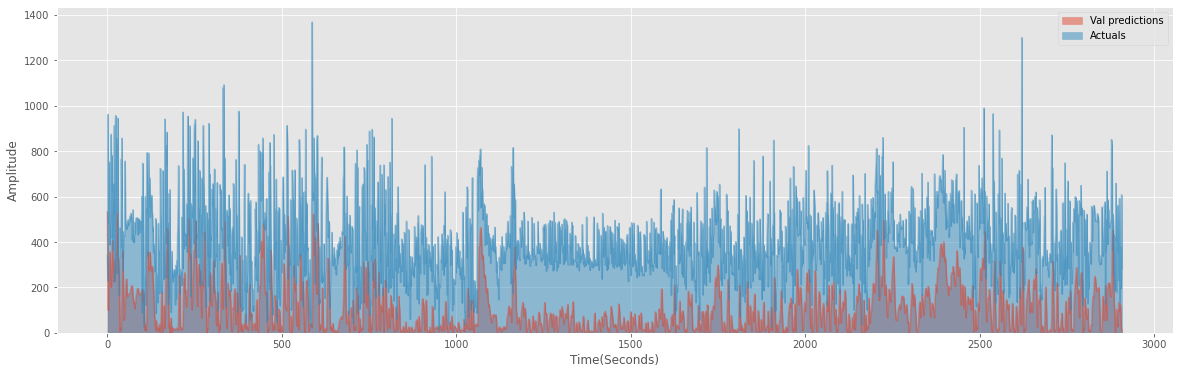

In [123]:
fig,ax = plt.subplots(figsize=(20,6))
val_results3.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

In [124]:
test_predictions3 = model3.predict(x_test).flatten()
test_results3 = pd.DataFrame(data={'Test predictions': test_predictions3, 'Actuals': y_test})
test_results3

,Test predictions,Actuals
0,10.731936,1318.891959
1,58.730392,427.907700
2,138.785538,308.974109
3,143.605515,375.431752
4,112.167610,315.995253
5,12.148401,323.487249
6,13.973378,281.128085
7,15.412031,346.161812
8,16.908867,294.266886
9,17.695442,291.756748


In [125]:
mape(test_predictions3, y_test)

1728.6281433958823

Text(0, 0.5, 'Amplitude')

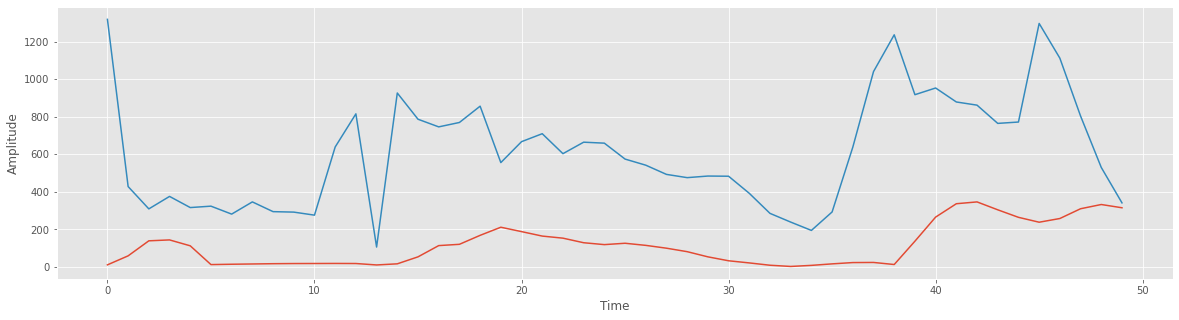

In [126]:
plt.plot(test_results3['Test predictions'])
plt.plot(test_results3['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

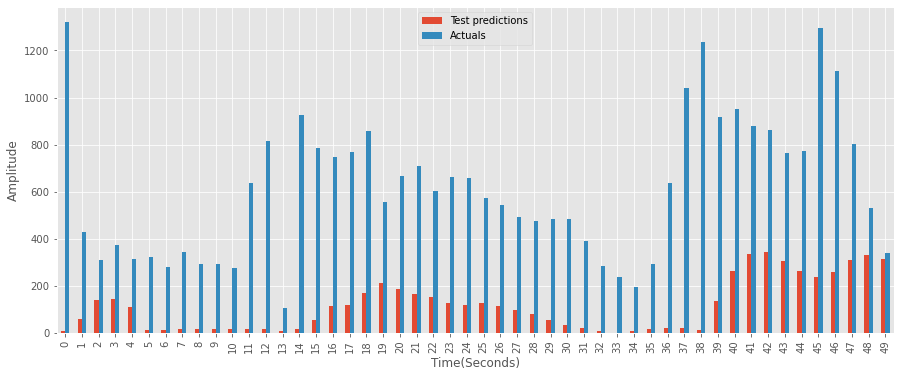

In [127]:
fig,ax = plt.subplots(figsize=(15,6))
test_results3.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

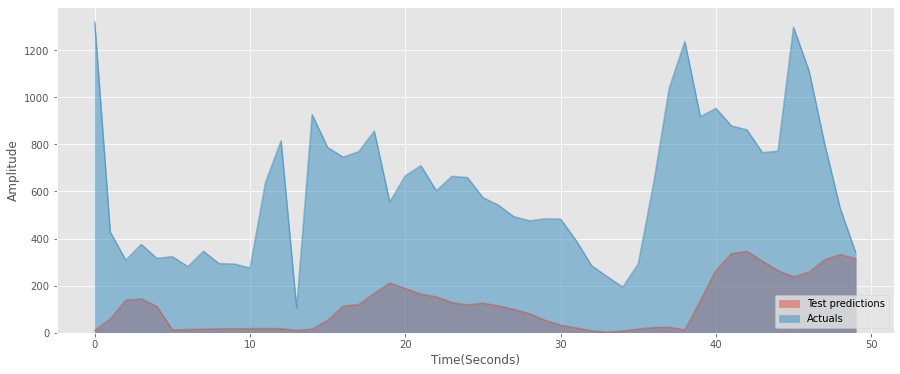

In [128]:
fig,ax = plt.subplots(figsize=(15,6))
test_results3.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()